# Ship Route Optimization
### Ahmed Ansari, Sarthak Choudhary, Manoj Arulmurugan

## Table of contents
1. [Introduction](#introduction)
2. [Mathematical Model](#mathematical_model)

## Introduction

1. What?

Freight ships are an important part of global trade today with total merchant ship estimated to be around 100,000 in number today [https://www.atlas-mag.net/en/category/tags/focus/the-world-merchant-fleet]. It is important in terms of time, cost and profitability to optimize the route that a merchant ship must take from its port of origin to all the ports that it must call upon.

In real life, there is a variety of objectives and constraints that define this interesting optimization problem. For example, a freight company may prioritize minimizing the fuel cost while ensuring that a ship visits all ports (in a set). There could be certain constraints such as the maximum distance the ship is allowed to travel between ports before it must refuel, or certain regions that it must avoid because of inclement weather, hostile waters, high levies, or congestion. It is also common for ships to exploit natural currents or for sail-driven ships to utilize wind directions to save on fuel and/or save time between its calls.

In many scenarios, objectives may even change mid-journey. For example, a crawler that starts from its port of origin, port A, visits a set of ports B, C and D and still has to   Frequently, there are certain zones that a ship might want to avoid, including hostile waters, shallow waters, inclement weather conditions, or regions with high ship density???

This problem is a variant of the **travelling salesman problem (TSP)**, although in this case, the underlying application, challenges and variety of possibilities is different from the classical problem. Discuss and describe differences.

What's being used in the industry and algorithms. Citations???

3. What is the scope of work

In this project, we limit ourselves to x??? interesting cases. We start of from a basic model to validate our ideas and iron out limitations with the constraints and issues with visualization. Some of these constraints (and their remedies) are described under their respective model.

We define the problem on an $n\times n$ grid of points. These points are traversable by a ship and are defined by a node index *and* a tuple of coordinates (x, y). These points can take the form of any of the following:
1. port of origin (POO)
2. port to call on
3. no-go zone
4. boost-zone

The number of ports to call-on, np-go zones and boost-zones are user-defined, and a function randomly assigns a node to these. Therefore, all data is user-input or randomized. This representation has the potential to be extended to an actual geographical maritime map as well, and allows ready visualization.

## Mathematical model

### Problem 1 - Base Problem and Issues
We impose a few constraints on our basic problem:
1. There is only one ship and only on port of origin
2. The ship must call on *all* the ports defined
3. The ship cannot revisit a port and it cannot return to the port of origin
4. No-go zones cannot be visited
5. The ship is only allowed to travel to the nearest 8 points around it on the grid, i.e. only to the points in a square around it.

#### Mathematical representation
**Sets**

**Decision variables**
$$x_{ij} \quad \text {from node i to j} \quad | \quad  x \in \{0, 1\} \, \forall i, j$$

\begin{equation}
x_{ij} =
    \begin{cases}
        0, & \text{if path } ij  \text{ is not on the ship route}\\
        1, & \text{if path } ij \text{ is on the ship route}
    \end{cases}
\end{equation}

**Constraints**

1. There is a single outflow from the port of origin.
$$\sum_{j \in nodes} x_{pj} = 1$$
2. There is no inflow to the port of origin.
$$\sum_{i \in nodes} x_{ip} = 0$$

## Solution

In [64]:
# Initializing Gurobi:

#=using Pkg
Pkg.add("Gurobi")
Pkg.build("Gurobi")=#

In [65]:
# Add packages here:

#=Pkg.add("Distributions")
Pkg.add("StatsBase")
Pkg.add("Juniper")
Pkg.add("PyPlot")
Pkg.add("MeshGrid")
Pkg.add("COSMO")
Pkg.add("StatsBase")
Pkg.add("LinearAlgebra")
Pkg.add("Random")
Pkg.add("Ipopt")
Pkg.add("Juniper")
Pkg.add("Printf")=#

In [66]:
using PyPlot, MeshGrid, StatsBase, LinearAlgebra, Random, Distributions

In [67]:
using JuMP, GLPK, COSMO, Gurobi, Juniper, Ipopt, Printf

### Helper Functions

In [68]:
function nodeToNum(node, n)
   return node[1]*n+node[2];
end

nodeToNum (generic function with 1 method)

In [69]:
function nodeToCoord(node, spacing)
   return spacing*node
end

nodeToCoord (generic function with 1 method)

In [70]:
function numToCoord(num, n, spacing)
    node_y = div.(num, n);
    node_x = num.%n;
    node = hcat(node_x, node_y);
    return spacing*node;
end

numToCoord (generic function with 1 method)

In [71]:
function numToNode(num, n)
    node_y = div.(num, n);
    node_x = num.%n;
    node = hcat(node_x, node_y);
    return node;
end

numToNode (generic function with 1 method)

In [72]:
function initializeParam(n, spacing, m, k, b, fill_ratio = 0.25)
    grid_size = n*n;
       
    # Check that values are whole numbers
    if m <= 1
        error("Increase m!")
    end
    
    # Check that values are whole numbers
    if !isinteger(n) || !isinteger(m) || !isinteger(k) || !isinteger(0)
        error("Only integer values are allowed for n, m and k!")
    end
        
    # Check that number of ports and no-go zones does not exceed a certain percentage of grid size
    if (b + k + m) >= fill_ratio*grid_size
        error("Number of ports and no-go zones cannot exceed $(fill_ratio*100)% of grid size. Reinitialize numnber of ports!")
    end
    
    grid_data = [n, spacing, m, k, b];
end

initializeParam (generic function with 2 methods)

In [73]:
function initializeParam_(n, spacing, m, k)
    grid_size = n*n;
       
    # Check that values are whole numbers
    if m <= 1
        error("Increase m!")
    end
    
    # Check that values are whole numbers
    if !isinteger(n) || !isinteger(m) || !isinteger(k)
        error("Only integer values are allowed for n, m and k!")
    end
        
    # Check that number of ports and no-go zones does not exceed a certain percentage of grid size
    fill_ratio = 0.25
    if (k + m) >= fill_ratio*grid_size
        error("Number of ports and no-go zones cannot exceed $(fill_ratio*100)% of grid size. Reinitialize numnber of ports!")
    end
    
    grid_data = [n, spacing, m, k];
end

initializeParam_ (generic function with 1 method)

In [74]:
function randomizePorts(grid_data)
### randomize location of all ports and no-go zones
   
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    m = Int(grid_data[3]);
    k = Int(grid_data[4]);

    # assign nodes to ports and no-go zones
    node = rand(0:n-1, m+k, 2);
    coord = spacing*node;

    port_coord = coord[1:m, :]
    no_go_coord = coord[m+1:end, :];

    # assign random port as port of origin
    rand_idx = rand(1:m);
    port_of_origin_coord = port_coord[rand_idx, :]

    return port_coord, no_go_coord, port_of_origin_coord
    
end

randomizePorts (generic function with 1 method)

In [75]:
function randomizePortsNoRepeat(grid_data)
### randomize location of all ports and no-go zones
   
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    m = Int(grid_data[3]);
    k = Int(grid_data[4]);

    total_nodes = n^2;
    pool = 0:(total_nodes-1);

    # assign nodes to ports and no-go zones
    nums = sample(pool, m+k, replace=false);
    port_num = nums[1:m, :];
    no_go_num = nums[m+1:end, :];
    
    # node = hcat(node_x, node_y)
    # coord = spacing*node;

    # port_node = numToNode(port_num, n);
    # port_coord = spacing*port_node;
    # no_go_node = numToNode(no_go_num, n);
    # no_go_coord = spacing*no_go_node;

    # assign random port as port of origin
    rand_idx = rand(1:m);
    port_of_origin_num = port_num[rand_idx];
    # port_of_origin_node = numToNode(port_of_origin_num, n);
    # port_of_origin_coord = spacing*port_of_origin_node;

    return port_num, port_of_origin_num, no_go_num
    
end

randomizePortsNoRepeat (generic function with 1 method)

In [76]:
function randomizePortsBoostZones(grid_data)
### randomize location of all ports and no-go zones and boost zones
   
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    m = Int(grid_data[3]);
    k = Int(grid_data[4]); # no-go 
    b = Int(grid_data[5]); # boost zones

    total_nodes = n^2;
    pool = 0:(total_nodes-1);

    # assign nodes to ports and no-go zones
    nums = sample(pool, m + k + b, replace=false);
    port_num = nums[1:m, :];
    no_go_num = nums[m+1:m+k, :];
    boost_num = nums[m+k+1:end, :];
    
    # node = hcat(node_x, node_y)
    # coord = spacing*node;

    # port_node = numToNode(port_num, n);
    # port_coord = spacing*port_node;
    # no_go_node = numToNode(no_go_num, n);
    # no_go_coord = spacing*no_go_node;

    # assign random port as port of origin
    rand_idx = rand(1:m);
    port_of_origin_num = port_num[rand_idx];
    # port_of_origin_node = numToNode(port_of_origin_num, n);
    # port_of_origin_coord = spacing*port_of_origin_node;

    return port_num, port_of_origin_num, no_go_num, boost_num
    
end

randomizePortsBoostZones (generic function with 1 method)

In [77]:
function generatePortPriorities(port_num, port_of_origin_num)
    visiting_ports = filter(p -> p != port_of_origin_num, port_num)
    
    port_priority = Dict{Int, Int}()
    for (priority_idx, port) in enumerate(visiting_ports)
        port_priority[port] = priority_idx
    end

    return port_priority
end

generatePortPriorities (generic function with 1 method)

In [78]:
function printVisitOrder(port_num, port_of_origin_num, y_opt)
    port_visit_order = []

    for idx in 1:length(port_num)
        port = port_num[idx]
        if port != port_of_origin_num
            push!(port_visit_order, (y_opt[idx], port))
        end
    end

    # Sort by visit order (y_opt values)
    sorted_ports = sort(port_visit_order, by=x->x[1])

    println("\n--- Port Visit Order ---")
    for (visit_num, port_id) in sorted_ports
        println("Visit port ", port_id, " at order ", visit_num)
    end
    println("------------------------\n")
end


printVisitOrder (generic function with 1 method)

In [79]:
function randomizePortProfit(grid_data, min_val, max_val)
# Randomize profit for each port    
    m = Int(grid_data[3]);

    return min_val .+ (max_val - min_val) .* rand(m);
end

randomizePortProfit (generic function with 1 method)

In [80]:
function visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, soln)
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    origin = [0, 0];

    port_coord = numToCoord(port_num, n, spacing);
    port_of_origin_coord = numToCoord(port_of_origin_num, n, spacing);
    no_go_coord = numToCoord(no_go_num, n, spacing);

    grid_size = n^2;

    grid_points_x = [origin[1] + i*spacing for i in range(0, n-1)];
    grid_points_y = [origin[2] + j*spacing for j in range(0, n-1)];

    grid_points_x, grid_points_y = meshgrid(grid_points_x, grid_points_y);
    # size(grid_points_mesh);

    grid_points = hcat(grid_points_x, grid_points_y);
    # grid_points = [grid_points_x, grid_points_y];
    size(grid_points);

    # plot
    grid_color_RGB = [248, 131, 121]./255;
    alpha_plot = 0.5;
    fig_size = max((10,10),(n, n));
    f = figure(figsize=(5, 5));
    scatter(grid_points_x, grid_points_y, alpha = alpha_plot, color = grid_color_RGB, s = 20);
    ax = gca();
    ax.axis("equal");
    ax.axis("off"); # hide axes spines/values

    # plot port data
    port_color_RGB = [25, 100, 50]./255;
    alpha_port = 1;
    scatter(port_coord[:, 1], port_coord[:, 2], alpha = alpha_port, color = port_color_RGB, marker = "o", s = 100);

    # plot no_go data
    no_go_color_RGB = [0, 0, 0]./255;
    alpha_no_go = 1;
    scatter(no_go_coord[:, 1], no_go_coord[:, 2], alpha = alpha_no_go, color = no_go_color_RGB, marker = "x", s = 150);

    # plot port of origin
    origin_port_color_RGB = [255, 87, 51]./255;
    alpha_origin_port = 1;
    scatter(port_of_origin_coord[1], port_of_origin_coord[2], alpha = alpha_origin_port, color = origin_port_color_RGB, marker = "*", s = 200);

    if soln != 0
        # plot edges
        for i=0:grid_size-1
            for j=0:grid_size-1
                if soln[i+1, j+1] == 1
                    # println(soln[i+1, j+1])
                    line_start = numToCoord(i, n, spacing);
                    line_end = numToCoord(j, n, spacing);

                    # println(line_start);
                    # println(line_end);
    
                    # plot([line_start[1], line_end[1]], [line_start[2], line_end[2]], "r-")
                    arrow(line_start[1], line_start[2],  line_end[1]-line_start[1], line_end[2]- line_start[2], head_width=0.2, head_length=0.2, fc="lightyellow", ec="orange")
                end
            end
        end
    end

    # plot([0, 1], [1, 2], "r-")
    return f 
end

visualizeGrid (generic function with 1 method)

In [81]:
function visualizeGridBoost(grid_data, port_num, port_of_origin_num, no_go_num, boost_num, soln)
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    origin = [0, 0];

    port_coord = numToCoord(port_num, n, spacing);
    port_of_origin_coord = numToCoord(port_of_origin_num, n, spacing);
    no_go_coord = numToCoord(no_go_num, n, spacing);
    boost_coord = numToCoord(boost_num, n, spacing);

    grid_size = n^2;

    grid_points_x = [origin[1] + i*spacing for i in range(0, n-1)];
    grid_points_y = [origin[2] + j*spacing for j in range(0, n-1)];

    grid_points_x, grid_points_y = meshgrid(grid_points_x, grid_points_y);
    # size(grid_points_mesh);

    grid_points = hcat(grid_points_x, grid_points_y);
    # grid_points = [grid_points_x, grid_points_y];
    size(grid_points);

    # plot
    grid_color_RGB = [248, 131, 121]./255;
    alpha_plot = 0.5;
    fig_size = max((10,10),(n, n));
    f = figure(figsize=(5, 5));
    scatter(grid_points_x, grid_points_y, alpha = alpha_plot, color = grid_color_RGB, s = 20);
    ax = gca();
    ax.axis("equal");
    ax.axis("off"); # hide axes spines/values

    # plot port data
    port_color_RGB = [25, 100, 50]./255;
    alpha_port = 1;
    scatter(port_coord[:, 1], port_coord[:, 2], alpha = alpha_port, color = port_color_RGB, marker = "o", s = 100);

    # plot no_go data
    no_go_color_RGB = [250, 0, 0]./255;
    alpha_no_go = 1;
    scatter(no_go_coord[:, 1], no_go_coord[:, 2], alpha = alpha_no_go, color = no_go_color_RGB, marker = "v", s = 50);

    # plot boost data
    if b != 0
        boost_color_RGB = [0, 0, 255]./255;
        alpha_boost = 1;
        scatter(boost_coord[:, 1], boost_coord[:, 2], alpha = alpha_boost, color = boost_color_RGB, marker = "^", s = 50);
    end
    
    # plot port of origin
    origin_port_color_RGB = [255, 87, 51]./255;
    alpha_origin_port = 1;
    scatter(port_of_origin_coord[1], port_of_origin_coord[2], alpha = alpha_origin_port, color = origin_port_color_RGB, marker = "*", s = 200);

    if soln != 0
        # plot edges
        for i=0:grid_size-1
            for j=0:grid_size-1
                if soln[i+1, j+1] == 1
                    # println(soln[i+1, j+1])
                    line_start = numToCoord(i, n, spacing);
                    line_end = numToCoord(j, n, spacing);

                    # println(line_start);
                    # println(line_end);
    
                    # plot([line_start[1], line_end[1]], [line_start[2], line_end[2]], "r-")
                    arrow(line_start[1], line_start[2],  line_end[1]-line_start[1], line_end[2]- line_start[2], head_width=0.2, head_length=0.2, fc="lightyellow", ec="orange")
                end
            end
        end
    end

    # plot([0, 1], [1, 2], "r-")
    return f 
end

visualizeGridBoost (generic function with 1 method)

In [82]:
function visualizeGridWithEdges(grid_data, port_num, port_of_origin_num, no_go_num, soln, c)
    n = Int(grid_data[1])
    spacing = grid_data[2]
    origin = [0, 0]

    port_coord = numToCoord(port_num, n, spacing)
    port_of_origin_coord = numToCoord(port_of_origin_num, n, spacing)
    no_go_coord = numToCoord(no_go_num, n, spacing)

    grid_size = n^2

    grid_points_x = [origin[1] + i*spacing for i in range(0, n-1)]
    grid_points_y = [origin[2] + j*spacing for j in range(0, n-1)]
    
    grid_points_x, grid_points_y = meshgrid(grid_points_x, grid_points_y)

    #Plot setup:
    f = figure(figsize=(30, 30))
    scatter(grid_points_x, grid_points_y, alpha=0.5, color=[248, 131, 121] ./ 255, s=250)
    ax = gca()
    ax.axis("equal")
    ax.axis("off")

    scatter(port_coord[:, 1], port_coord[:, 2], alpha=1, color=[25, 100, 50] ./ 255, marker="*", s=600)

    scatter(no_go_coord[:, 1], no_go_coord[:, 2], alpha=1, color=[0, 0, 0], marker="x", s=520, linewidths=2)

    scatter(port_of_origin_coord[1], port_of_origin_coord[2], alpha=1, color=[255, 87, 51] ./ 255, marker="*", s=700)

    base_shift = 0.25   #Along the line
    second_shift = 0.25 #A bit further along the line
    
    for i = 0:grid_size-1
        for j = 0:grid_size-1
            if i < j && c[i+1, j+1] > 0
                node_i = numToNode(i, n)
                node_j = numToNode(j, n)
    
                if abs(node_i[1] - node_j[1]) <= 1 && abs(node_i[2] - node_j[2]) <= 1
                    line_start = numToCoord(i, n, spacing)
                    line_end = numToCoord(j, n, spacing)
    
                    plot([line_start[1], line_end[1]],
                         [line_start[2], line_end[2]],
                         color="black", alpha=0.3, linewidth=1)
    
                    #Midpoint:
                    mid_x = (line_start[1] + line_end[1]) / 2
                    mid_y = (line_start[2] + line_end[2]) / 2
    
                    #Line direction unit vector:
                    dx = line_end[1] - line_start[1]
                    dy = line_end[2] - line_start[2]
                    norm_factor = sqrt(dx^2 + dy^2)
                    unit_dx = dx / norm_factor
                    unit_dy = dy / norm_factor
    
                    # First label: shift toward j
                    text(mid_x + base_shift*unit_dx, mid_y + base_shift*unit_dy,
                         @sprintf("↑%.2f", c[i+1, j+1]),
                         fontsize=15, ha="center", va="center", color="blue")
    
                    # Second label: shift toward i
                    text(mid_x - second_shift*unit_dx, mid_y - second_shift*unit_dy,
                         @sprintf("↓%.2f", c[j+1, i+1]),
                         fontsize=15, ha="center", va="center", color="red")
                end
            end
        end
    end
        if soln != 0
            for i = 0:grid_size-1
                for j = 0:grid_size-1
                    if soln[i+1, j+1] == 1
                        line_start = numToCoord(i, n, spacing)
                        line_end = numToCoord(j, n, spacing)
    
                        arrow(line_start[1], line_start[2],
                              line_end[1] - line_start[1],
                              line_end[2] - line_start[2],
                              head_width=0.15, head_length=0.2,
                              fc="black", ec="black")
                    end
                end
            end
        end
    
        return f
    end

visualizeGridWithEdges (generic function with 1 method)

In [83]:
function visualizeGridWithEdgesSol(grid_data, port_num, port_of_origin_num, no_go_num, soln, c)
    n = Int(grid_data[1])
    spacing = grid_data[2]
    origin = [0, 0]

    port_coord = numToCoord(port_num, n, spacing)
    port_of_origin_coord = numToCoord(port_of_origin_num, n, spacing)
    no_go_coord = numToCoord(no_go_num, n, spacing)

    grid_size = n^2

    grid_points_x = [origin[1] + i*spacing for i in range(0, n-1)]
    grid_points_y = [origin[2] + j*spacing for j in range(0, n-1)]
    grid_points_x, grid_points_y = meshgrid(grid_points_x, grid_points_y)

    #Plot setup:
    f = figure(figsize=(5, 5))
    scatter(grid_points_x, grid_points_y, alpha=0.5, color=[248, 131, 121] ./ 255, s=20)
    ax = gca()
    ax.axis("equal")
    ax.axis("off")

    scatter(port_coord[:, 1], port_coord[:, 2], alpha=1, color=[25, 100, 50] ./ 255, marker="*", s=200)

    scatter(no_go_coord[:, 1], no_go_coord[:, 2], alpha=1, color=[0, 0, 0], marker="x", s=120, linewidths=2)

    scatter(port_of_origin_coord[1], port_of_origin_coord[2], alpha=1, color=[255, 87, 51] ./ 255, marker="*", s=300)

    if soln != 0
        for i = 0:grid_size-1
            for j = 0:grid_size-1
                if soln[i+1, j+1] == 1
                    line_start = numToCoord(i, n, spacing)
                    line_end = numToCoord(j, n, spacing)

                    arrow(line_start[1], line_start[2],
                          line_end[1] - line_start[1],
                          line_end[2] - line_start[2],
                          head_width=0.15, head_length=0.2,
                          fc="black", ec="black")

                    #Midpoint:
                    mid_x = (line_start[1] + line_end[1]) / 2
                    mid_y = (line_start[2] + line_end[2]) / 2

                    #Offset the label perpendicular to the edge direction:
                    dx = line_end[1] - line_start[1]
                    dy = line_end[2] - line_start[2]
                    norm_factor = sqrt(dx^2 + dy^2)
                    unit_dx = dx / norm_factor
                    unit_dy = dy / norm_factor

                    #Perpendicular vector:
                    perp_dx = -unit_dy
                    perp_dy = unit_dx

                    label_offset = 0.2

                    text(mid_x + label_offset*perp_dx, mid_y + label_offset*perp_dy,
                         @sprintf("%.2f", c[i+1, j+1]),
                         fontsize=6, ha="center", va="center", color="black")
                end
            end
        end
    end

    return f
end

visualizeGridWithEdgesSol (generic function with 1 method)

In [84]:
using PyPlot
using Printf

function visualizeGridWithPriorities(grid_data, port_num, port_of_origin_num, no_go_num, soln, port_priority)
    clf()  # Clear previous plots

    n = Int(grid_data[1])
    spacing = grid_data[2]
    origin = [0, 0]

    port_coord = numToCoord(port_num, n, spacing)
    port_of_origin_coord = numToCoord(port_of_origin_num, n, spacing)
    no_go_coord = numToCoord(no_go_num, n, spacing)

    grid_size = n^2

    grid_points_x = [origin[1] + i*spacing for i in range(0, n-1)]
    grid_points_y = [origin[2] + j*spacing for j in range(0, n-1)]
    grid_points_x, grid_points_y = meshgrid(grid_points_x, grid_points_y)

    # plot
    grid_color_RGB = [248, 131, 121] ./ 255
    alpha_plot = 0.5
    fig_size = max((10,10), (n, n))
    f = figure(figsize=(5, 5))
    scatter(grid_points_x, grid_points_y, alpha=alpha_plot, color=grid_color_RGB, s=20)
    ax = gca()
    ax.axis("equal")
    ax.axis("off") 

    # plot port data
    port_color_RGB = [25, 100, 50] ./ 255
    alpha_port = 1
    scatter(port_coord[:, 1], port_coord[:, 2], alpha=alpha_port, color=port_color_RGB, marker="*", s=100)

    for idx in 1:length(port_num)
        port_id = port_num[idx]
        if haskey(port_priority, port_id)
            x, y = port_coord[idx, 1], port_coord[idx, 2]
            # Format: "priority (port_id)"
            text(x, y + 0.5, @sprintf("%d (%d)", port_priority[port_id], port_id),
                 fontsize=8, ha="center", va="bottom", color="black")
        end
    end

    # plot no_go data
    no_go_color_RGB = [0, 0, 0]
    alpha_no_go = 1
    scatter(no_go_coord[:, 1], no_go_coord[:, 2], alpha=alpha_no_go, color=no_go_color_RGB, marker="x", s=80)

    # plot port of origin (bigger and different color)
    origin_port_color_RGB = [255, 87, 51] ./ 255
    alpha_origin_port = 1
    scatter(port_of_origin_coord[1], port_of_origin_coord[2], alpha=alpha_origin_port, color=origin_port_color_RGB, marker="*", s=200)

    if soln != 0
        # plot solution edges
        for i = 0:grid_size-1
            for j = 0:grid_size-1
                if soln[i+1, j+1] == 1
                    line_start = numToCoord(i, n, spacing)
                    line_end = numToCoord(j, n, spacing)

                    arrow(line_start[1], line_start[2],
                          line_end[1] - line_start[1], line_end[2] - line_start[2],
                          head_width=0.3, head_length=0.3, alpha =0.5,
                          fc="lightyellow", ec="black")
                end
            end
        end
    end

    return f
end

visualizeGridWithPriorities (generic function with 1 method)

### Minimize total distance travelled

In [85]:
function optModelMinCost(grid_data, port_num, port_of_origin_num, no_go_num, solver)
    grid_size = n*n;

    # nodes other than ports and no-go zones
    all_num = [i for i=0:grid_size-1];
    all_else_num = setdiff(all_num, union(port_num, no_go_num))
    # println(all_else_num)
    
    model = Model();
    # all edges from a node to all other nodes
    # @show 
    @variable(model, x[i = 0:grid_size-1, j = 0:grid_size-1], Bin);
    # @show 
    @variable(model, z[i = 1:m], Bin);
    
    # MTZ to prevent loops
    # defined for all nodes
    # u is a continuous variable initialized at the port of origin to be 0
    @variable(model, u[i = 0:grid_size-1] >= 0);
    @constraint(model, u[1] == 0) # for POO;
    
    # edge cost: euclidean norm
    c = zeros(grid_size, grid_size);
    
    tol = 10^-5;

    # Total cost
    cost = 0; 
    
    # idx=0;
    
    # cost and same node flow
    for i = 0:grid_size-1
        # println(i);
    
        for j = 0:grid_size-1
            if i == j
                # no flow
                # @show 
                @constraint(model, x[i, j] == 0);
            end

            # MTZ constraint
            @constraint(model, u[i]- u[j] + grid_size*x[i, j] <= grid_size - 1);
    
            # edge cost
            c[i+1, j+1] = norm(numToCoord(i, n, spacing)- numToCoord(j, n, spacing));
            cost += c[i+1, j+1]*x[i, j];
              
            # all edges other than the eight closest ones are zero 
            if c[i+1, j+1] > (sqrt(2) + tol)
                @constraint(model, x[i, j] == 0);
            end    
        end   
    end
    
    # port of origin
    sum_in_POO = 0;
    sum_out_POO = 0;
    
    for j = 0:grid_size-1
        sum_out_POO += x[port_of_origin_num, j];
        sum_in_POO += x[j, port_of_origin_num]; 
    end
    
    # @show 
    @constraint(model, sum_out_POO==1);
    # @show 
    @constraint(model, sum_out_POO - sum_in_POO == 1); # or sum in == 0
    
    ## for other ports
    # for if-then constraints
    e = 1;
    l = -1;
    u = 2;
    sum_terminal = 0;
    
    for p=1:length(port_num)
        i = port_num[p];
        if i!=port_of_origin_num
            # println(i);
            sum_in_port = 0;
            sum_out_port = 0;
    
            for j = 0:grid_size-1
                # port of origin
                sum_out_port += x[i, j];
                sum_in_port += x[j, i];
    
                # if flow from edge is 1, then no flow in the opposite direction
                # @show 
                @constraint(model, x[i, j] + x[j, i] <= 1);
               
            end

            ## if-then constraints
            # @show 
            # @constraint(model, sum_out_port >= l*z[p] +e*(1-z[p]));
            # @show 
            # @constraint(model, sum_out_port <= u*(1-z[p]));
            # @show 
            @constraint(model, sum_in_port == 1);
            # @constraint(model, sum_in_port >= 1);
            # @show 
            @constraint(model, sum_out_port - sum_in_port <= 0);
    
            # sum_terminal += z[p];
        end
    end
    # @show 
    # @constraint(model, sum_terminal == 1);
    
    
    # for no-go zones
    for g=1:length(no_go_num)
        i = no_go_num[g];
        
        # println(i);
        
        sum_in_no_go = 0;
        sum_out_no_go = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_no_go += x[i, j];
            sum_in_no_go += x[j, i];
        
           
        end
        # @show 
        @constraint(model, sum_out_no_go == 0);
        # @show 
        @constraint(model, sum_in_no_go == 0);
        
    end
    
    # for all-else
    for a=1:length(all_else_num)
        i = all_else_num[a];
        
        # println(i);
        
        sum_out_all_else = 0;
        sum_in_all_else = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_all_else += x[i, j];
            sum_in_all_else += x[j, i];
    
            # if flow from edge is 1, then no flow in the opposite direction
            # @show 
            # @constraint(model, x[i, j] + x[j, i] <= 1);
           
        end
        # @show 
        @constraint(model, sum_out_all_else - sum_in_all_else == 0);
        
    end
    
    #objective function
    @objective(model, Min, cost);

    set_optimizer(model, solver.Optimizer);
    set_silent(model);
    optimize!(model);

    println(termination_status(model));

    try
        x_opt = JuMP.value.(x);
        z_opt = JuMP.value.(z);
        obj_opt = objective_value(model);
        
        return x_opt, z_opt, obj_opt, model
    catch
    # else
        error("Model did not optimize!")
    end

end

optModelMinCost (generic function with 1 method)

### Allow ship to pass through no-go zones but assign penalty

In [86]:
function optModelAllowNoGo(grid_data, port_num, port_of_origin_num, no_go_num, penalty_factor, solver)
    grid_size = n*n;

    # nodes other than ports and no-go zones
    all_num = [i for i=0:grid_size-1];
    all_else_num = setdiff(all_num, union(port_num, no_go_num))
    # println(all_else_num)
    
    model = Model();
    # all edges from a node to all other nodes
    # @show 
    @variable(model, x[i = 0:grid_size-1, j = 0:grid_size-1], Bin);
    # @show 
    @variable(model, z[i = 1:m], Bin);
    
    # MTZ to prevent loops
    # defined for all nodes
    # u is a continuous variable initialized at the port of origin to be 0
    @variable(model, u[i = 0:grid_size-1] >= 0);
    @constraint(model, u[1] == 0) # for POO;
    
    # edge cost: euclidean norm
    norm_dist = zeros(grid_size, grid_size);
    c = zeros(grid_size, grid_size);
    
    tol = 10^-5;
    
    cost = 0; 
    
    # idx=0;
    # cost and same node flow
    for i = 0:grid_size-1
        # println(i);
    
        for j = 0:grid_size-1
            if i == j
                # no flow
                # @show 
                @constraint(model, x[i, j] == 0);
            end

            # MTZ constraint
            @constraint(model, u[i]- u[j] + grid_size*x[i, j] <= grid_size - 1);
    
            # edge cost
            norm_dist[i+1, j+1] = norm(numToCoord(i, n, spacing) - numToCoord(j, n, spacing));
            c[i+1, j+1] = norm_dist[i+1, j+1];
            
            # If flow coming in or going out of a no-go zone, increase cost by 1.5
            if in(i, no_go_num) || in(j, no_go_num)
                c[i+1, j+1] *= penalty_factor;              
            end

            cost += c[i+1, j+1]*x[i, j];
            
            # all edges other than the eight closest ones are zero 
            if norm_dist[i+1, j+1] > (sqrt(2) + tol)
                @constraint(model, x[i, j] == 0);
            end    
        end   
        
    end
    
    # port of origin
    sum_in_POO = 0;
    sum_out_POO = 0;
    
    for j = 0:grid_size-1
        sum_out_POO += x[port_of_origin_num, j];
        sum_in_POO += x[j, port_of_origin_num]; 
    end
    
    # @show 
    @constraint(model, sum_out_POO == 1);
    # @show 
    @constraint(model, sum_out_POO - sum_in_POO == 1);
    
    ## for other ports
    # for if-then constraints
    e = 1; # epsilon
    l = -1; # lower bound
    u = 2; # upper bound
    sum_terminal = 0;
    
    for p=1:length(port_num)
        i = port_num[p];
        if i!=port_of_origin_num
            # println(i);
            sum_in_port = 0;
            sum_out_port = 0;
    
            for j = 0:grid_size-1
                # port of origin
                sum_out_port += x[i, j];
                sum_in_port += x[j, i];
    
                # if flow from edge is 1, then no flow in the opposite direction
                # @show 
                @constraint(model, x[i, j] + x[j, i] <= 1);
               
            end

            ## if-then constraints
            # @show 
            # @constraint(model, sum_out_port >= l*z[p] +e*(1-z[p]));
            # # @show 
            # @constraint(model, sum_out_port <= u*(1-z[p]));
            # @show 
            @constraint(model, sum_in_port == 1);
            # @constraint(model, sum_in_port >= 1);
            # @show 
            @constraint(model, sum_out_port - sum_in_port <= 0);
    
            # sum_terminal += z[p];
        end
    end
    # @show 
    # @constraint(model, sum_terminal == 1);
    
    
    # for no-go zones
    for g=1:length(no_go_num)
        i = no_go_num[g];
        
        # println(i);
        
        sum_in_no_go = 0;
        sum_out_no_go = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_no_go += x[i, j];
            sum_in_no_go += x[j, i];
        
        end

        # conserve flow
        @constraint(model, sum_out_no_go - sum_in_no_go ==0);
        
    end
    
    # for all-else
    for a=1:length(all_else_num)
        i = all_else_num[a];
        
        # println(i);
        
        sum_out_all_else = 0;
        sum_in_all_else = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_all_else += x[i, j];
            sum_in_all_else += x[j, i];
    
            # if flow from edge is 1, then no flow in the opposite direction
            # @show 
            # @constraint(model, x[i, j] + x[j, i] <= 1);
           
        end
        # @show 
        @constraint(model, sum_out_all_else - sum_in_all_else == 0);
        
    end
    
    #objective function
    @objective(model, Min, cost);

    @show model

    set_optimizer(model, solver.Optimizer);
    # set_silent(model);
    optimize!(model);

    println(termination_status(model));

    try
        x_opt = JuMP.value.(x);
        z_opt = JuMP.value.(z);
        obj_opt = objective_value(model);
            
        return x_opt, z_opt, obj_opt, model
    catch
    # else
        error("Model did not optimize!")
    end

end

optModelAllowNoGo (generic function with 1 method)

### With Boost Zones

In [87]:
function optModelNoGoBoost(grid_data, port_num, port_of_origin_num, no_go_num, boost_num, penalty_factor, boost_factor, solver)
    grid_size = n*n;

    # nodes other than ports and no-go zones
    all_num = [i for i=0:grid_size-1];
    all_else_num = setdiff(all_num, union(port_num, no_go_num, boost_num))
    # println(all_else_num)
    
    model = Model();
    # all edges from a node to all other nodes
    # @show 
    @variable(model, x[i = 0:grid_size-1, j = 0:grid_size-1], Bin);
    # @show 
    @variable(model, z[i = 1:m], Bin);
    
    # MTZ to prevent loops
    # defined for all nodes
    # u is a continuous variable initialized at the port of origin to be 0
    @variable(model, u[i = 0:grid_size-1] >= 0);
    @constraint(model, u[1] == 0) # for POO;
    
    # edge cost: euclidean norm
    norm_dist = zeros(grid_size, grid_size);
    c = zeros(grid_size, grid_size);
    
    tol = 10^-5;
    
    cost = 0; 
    
    # idx=0;
    # cost and same node flow
    for i = 0:grid_size-1
        # println(i);
    
        for j = 0:grid_size-1
            if i == j
                # no flow
                # @show 
                @constraint(model, x[i, j] == 0);
            end

            # MTZ constraint
            @constraint(model, u[i]- u[j] + grid_size*x[i, j] <= grid_size - 1);
    
            # edge cost
            norm_dist[i+1, j+1] = norm(numToCoord(i, n, spacing) - numToCoord(j, n, spacing));
            c[i+1, j+1] = norm_dist[i+1, j+1];
            
            # If flow coming going out of a no-go zone, increase cost by penalty factor
            # if in(i, no_go_num) || in(j, no_go_num)
            if in(j, no_go_num)
                c[i+1, j+1] *= penalty_factor;              
            end

             # If flow coming into a boost zone, decrease cost by boost factor
            if in(j, boost_num)
                c[i+1, j+1] /= boost_factor;              
            end

            cost += c[i+1, j+1]*x[i, j];
            
            # all edges other than the eight closest ones are zero 
            if norm_dist[i+1, j+1] > (sqrt(2) + tol)
                @constraint(model, x[i, j] == 0);
            end    
        end   
        
    end
    
    # port of origin
    sum_in_POO = 0;
    sum_out_POO = 0;
    
    for j = 0:grid_size-1
        sum_out_POO += x[port_of_origin_num, j];
        sum_in_POO += x[j, port_of_origin_num]; 
    end
    
    # @show 
    @constraint(model, sum_out_POO == 1);
    # @show 
    @constraint(model, sum_out_POO - sum_in_POO == 1);
    
    ## for other ports
    # for if-then constraints
    e = 1; # epsilon
    l = -1; # lower bound
    u = 2; # upper bound
    sum_terminal = 0;
    
    for p=1:length(port_num)
        i = port_num[p];
        if i!=port_of_origin_num
            # println(i);
            sum_in_port = 0;
            sum_out_port = 0;
    
            for j = 0:grid_size-1
                # port of origin
                sum_out_port += x[i, j];
                sum_in_port += x[j, i];
    
                # if flow from edge is 1, then no flow in the opposite direction
                # @show 
                @constraint(model, x[i, j] + x[j, i] <= 1);
               
            end

            ## if-then constraints
            # @show 
            # @constraint(model, sum_out_port >= l*z[p] +e*(1-z[p]));
            # # @show 
            # @constraint(model, sum_out_port <= u*(1-z[p]));
            # @show 
            @constraint(model, sum_in_port == 1);
            # @constraint(model, sum_in_port >= 1);
            # @show 
            @constraint(model, sum_out_port - sum_in_port <= 0);
    
            # sum_terminal += z[p];
        end
    end
    # @show 
    # @constraint(model, sum_terminal == 1);
    
     # for boost zones
    for b=1:length(boost_num)
        i = boost_num[b];
        
        # println(i);
        
        sum_in_boost = 0;
        sum_out_boost = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_boost += x[i, j];
            sum_in_boost += x[j, i];
        
        end

        # conserve flow
        @constraint(model, sum_out_boost - sum_in_boost ==0);
        
    end
    
    # for no-go zones
    for g=1:length(no_go_num)
        i = no_go_num[g];
        
        # println(i);
        
        sum_in_no_go = 0;
        sum_out_no_go = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_no_go += x[i, j];
            sum_in_no_go += x[j, i];
        
        end

        # conserve flow
        @constraint(model, sum_out_no_go - sum_in_no_go ==0);
        
    end
    
    # for all-else
    for a=1:length(all_else_num)
        i = all_else_num[a];
        
        # println(i);
        
        sum_out_all_else = 0;
        sum_in_all_else = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_all_else += x[i, j];
            sum_in_all_else += x[j, i];
    
            # if flow from edge is 1, then no flow in the opposite direction
            # @show 
            # @constraint(model, x[i, j] + x[j, i] <= 1);
           
        end
        # @show 
        @constraint(model, sum_out_all_else - sum_in_all_else == 0);
        
    end
    
    #objective function
    @objective(model, Min, cost);

    @show model

    set_optimizer(model, solver.Optimizer);
    # set_silent(model);
    optimize!(model);

    println(termination_status(model));

    try
        x_opt = JuMP.value.(x);
        z_opt = JuMP.value.(z);
        obj_opt = objective_value(model);
            
        return x_opt, z_opt, obj_opt, model
    catch
    # else
        error("Model did not optimize!")
    end

end

optModelNoGoBoost (generic function with 1 method)

### Allow any number of ports to be visited >= 1

In [88]:
function optModelMaxProfit(grid_data, port_num, port_of_origin_num, no_go_num, port_profit, solver)
    grid_size = n*n;

    # nodes other than ports and no-go zones
    all_num = [i for i=0:grid_size-1];
    all_else_num = setdiff(all_num, union(port_num, no_go_num))
    # println(all_else_num)
    
    model = Model();
    # all edges from a node to all other nodes
    # @show 
    @variable(model, x[i = 0:grid_size-1, j = 0:grid_size-1], Bin);
    # @show 
    @variable(model, z[i = 1:length(port_num)], Bin);

    # binary variable to ensure >= 1 ports visited (other than POO)
    @variable(model, w[i = 1:length(port_num)], Bin);
    
    # MTZ to prevent loops
    # defined for all nodes
    # u is a continuous variable initialized at the port of origin to be 0
    @variable(model, u[i = 0:grid_size-1] >= 0);
    @constraint(model, u[1] == 0) # for POO;
    
    # edge cost: euclidean norm
    c = zeros(grid_size, grid_size);
    
    tol = 10^-5;

    # Total cost
    cost = 0; 
    
    # idx=0;
    
    # cost and same node flow
    for i = 0:grid_size-1
        # println(i);
    
        for j = 0:grid_size-1
            if i == j
                # no flow
                # @show 
                @constraint(model, x[i, j] == 0);
            end

            # MTZ constraint
            @constraint(model, u[i]- u[j] + grid_size*x[i, j] <= grid_size - 1);
    
            # edge cost
            c[i+1, j+1] = norm(numToCoord(i, n, spacing)- numToCoord(j, n, spacing));
            cost += c[i+1, j+1]*x[i, j];
              
            # all edges other than the eight closest ones are zero 
            if c[i+1, j+1] > (sqrt(2) + tol)
                @constraint(model, x[i, j] == 0);
            end   
        end   
    end
    
    # port of origin
    sum_in_POO = 0;
    sum_out_POO = 0;
    
    for j = 0:grid_size-1
        sum_out_POO += x[port_of_origin_num, j];
        sum_in_POO += x[j, port_of_origin_num]; 
    end
    
    # @show 
    @constraint(model, sum_out_POO==1);
    # @show 
    @constraint(model, sum_out_POO - sum_in_POO == 1); # or sum in == 0
    
    ## for other ports
    # for if-then constraints
    e = 1;
    l = -1;
    u = 2;
    sum_terminal = 0;
    profit = 0;
    
    for p=1:length(port_num)
        i = port_num[p];
        if i!=port_of_origin_num
            # println(i);
            sum_in_port = 0;
            sum_out_port = 0;
    
            for j = 0:grid_size-1
                # port of origin
                sum_out_port += x[i, j];
                sum_in_port += x[j, i];
    
                # if flow from edge is 1, then no flow in the opposite direction
                # @show 
                @constraint(model, x[i, j] + x[j, i] <= 1);
               
            end

            ## if-then constraints
            # @show 
            # @constraint(model, sum_out_port >= l*z[p] +e*(1-z[p]));
            # @show 
            # @constraint(model, sum_out_port <= u*(1-z[p]));
            # @show 
            # @constraint(model, sum_in_port == 1);
            # @constraint(model, sum_in_port >= 1);
            # @show 
            @constraint(model, sum_out_port - sum_in_port <= 0);

            # Added constraint to esnure >= 1 ports visited; this allows skipping some ports
            @constraint(model, sum_in_port - 1 <= u*w[p] - e*(1-w[p])); # if sum_in >=1, w = 1
            @constraint(model, sum_in_port >= l*(1-w[p]) + e*w[p]); # if sum_in <=0, w = 0

            profit += port_profit[p]*w[p];
            # sum_terminal += z[p];
        else
            @constraint(model, w[p] == 0); # for port of origin, redundant?
        end
    end
    # @show 
    # @constraint(model, sum_terminal == 1);
    
    
    # for no-go zones
    for g=1:length(no_go_num)
        i = no_go_num[g];
        
        # println(i);
        
        sum_in_no_go = 0;
        sum_out_no_go = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_no_go += x[i, j];
            sum_in_no_go += x[j, i];
        
           
        end
        # @show 
        @constraint(model, sum_out_no_go == 0);
        # @show 
        @constraint(model, sum_in_no_go == 0);
        
    end
    
    # for all-else
    for a=1:length(all_else_num)
        i = all_else_num[a];
        
        # println(i);
        
        sum_out_all_else = 0;
        sum_in_all_else = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_all_else += x[i, j];
            sum_in_all_else += x[j, i];
    
            # if flow from edge is 1, then no flow in the opposite direction
            # @show 
            # @constraint(model, x[i, j] + x[j, i] <= 1);
           
        end
        # @show 
        @constraint(model, sum_out_all_else - sum_in_all_else == 0);
        
    end
    
    #objective function
    # @objective(model, Min, cost);
    @objective(model, Max, profit);

    set_optimizer(model, solver.Optimizer);
    set_silent(model);
    optimize!(model);

    println(termination_status(model));

    try
        x_opt = JuMP.value.(x);
        z_opt = JuMP.value.(z);
        obj_opt = objective_value(model);
        
        return x_opt, z_opt, obj_opt, model
    catch
    # else
        error("Model did not optimize!")
    end

end

optModelMaxProfit (generic function with 1 method)

### Maximized Profit with a max limit between any two ports

In [89]:
function optModelMaxProfitwithMaxDist(grid_data, port_num, port_of_origin_num, no_go_num, port_profit, d_max, solver)
    grid_size = n*n;

    # nodes other than ports and no-go zones
    all_num = [i for i=0:grid_size-1];
    all_else_num = setdiff(all_num, union(port_num, no_go_num))
    # println(all_else_num)
    
    model = Model();
    # all edges from a node to all other nodes
    # @show 
    @variable(model, x[i = 0:grid_size-1, j = 0:grid_size-1], Bin);
    # @show 
    @variable(model, z[i = 1:length(port_num)], Bin);

    # binary variable to ensure >= 1 ports visited (other than POO)
    @variable(model, w[i = 1:length(port_num)], Bin);
    
    # MTZ to prevent loops
    # defined for all nodes
    # u is a continuous variable initialized at the port of origin to be 0
    @variable(model, u[i = 0:grid_size-1] >= 0);
    @constraint(model, u[1] == 0) # for POO;

    # Port-to-port distance tracking 
    # Track distance since last port for each node 
    @variable(model, d[i=0:grid_size-1] >= 0)
    
    for p in port_num
        @constraint(model, d[p] == 0);
    end
    
    # edge cost: euclidean norm
    c = zeros(grid_size, grid_size);
    
    tol = 10^-5;
    # d_max = 7;
    # Total cost
    cost = 0; 
    
    idx=0;
    
    # cost and same node flow
    for i = 0:grid_size-1
        # println(i);
    
        for j = 0:grid_size-1
            if i == j
                # no flow
                # @show 
                @constraint(model, x[i, j] == 0);
            end

            # MTZ constraint
            @constraint(model, u[i]- u[j] + grid_size*x[i, j] <= grid_size - 1);
    
            # edge cost
            c[i+1, j+1] = norm(numToCoord(i, n, spacing)- numToCoord(j, n, spacing));
            cost += c[i+1, j+1]*x[i, j];
              
            # all edges other than the eight closest ones are zero 
            if c[i+1, j+1] > (sqrt(2) + tol)
                @constraint(model, x[i, j] == 0);
            end   
            # update distance tracking between nodes
            # If we travel from i to j, update the distance tracking 
            if !in(j, port_num) # Only needed for non-port grid points
                @constraint(model, d[j] >= d[i] + c[i+1, j+1] - d_max*(1 - x[i,j]));
            end

            # Ensure distance between ports doesn't exceed d_max
            @constraint(model, d[j] <= d_max);
        end   
    end
    
    # port of origin
    sum_in_POO = 0;
    sum_out_POO = 0;
    
    for j = 0:grid_size-1
        sum_out_POO += x[port_of_origin_num, j];
        sum_in_POO += x[j, port_of_origin_num]; 
    end
    
    # @show 
    @constraint(model, sum_out_POO==1);
    # @show 
    @constraint(model, sum_out_POO - sum_in_POO == 1); # or sum in == 0
    
    ## for other ports
    # for if-then constraints
    e = 1;
    l = -1;
    u = 2;
    sum_terminal = 0;
    profit = 0;
    
    for p=1:length(port_num)
        i = port_num[p];
        if i!=port_of_origin_num
            # println(i);
            sum_in_port = 0;
            sum_out_port = 0;
    
            for j = 0:grid_size-1
                # port of origin
                sum_out_port += x[i, j];
                sum_in_port += x[j, i];
    
                # if flow from edge is 1, then no flow in the opposite direction
                # @show 
                @constraint(model, x[i, j] + x[j, i] <= 1);
               
            end

            ## if-then constraints
            # @show 
            # @constraint(model, sum_out_port >= l*z[p] +e*(1-z[p]));
            # @show 
            # @constraint(model, sum_out_port <= u*(1-z[p]));
            # @show 
            # @constraint(model, sum_in_port == 1);
            # @constraint(model, sum_in_port >= 1);
            # @show 
            @constraint(model, sum_out_port - sum_in_port <= 0);

            # Added constraint to esnure >= 1 ports visited; this allows skipping some ports
            @constraint(model, sum_in_port - 1 <= u*w[p] - e*(1-w[p])); # if sum_in >=1, w = 1
            @constraint(model, sum_in_port >= l*(1-w[p]) + e*w[p]); # if sum_in <=0, w = 0

            profit += port_profit[p]*w[p];
            # sum_terminal += z[p];
        else
            @constraint(model, w[p] == 0); # for port of origin, redundant?
        end
    end
    # @show 
    # @constraint(model, sum_terminal == 1);
    
    
    # for no-go zones
    for g=1:length(no_go_num)
        i = no_go_num[g];
        
        # println(i);
        
        sum_in_no_go = 0;
        sum_out_no_go = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_no_go += x[i, j];
            sum_in_no_go += x[j, i];
        
           
        end
        # @show 
        @constraint(model, sum_out_no_go == 0);
        # @show 
        @constraint(model, sum_in_no_go == 0);
        
    end
    
    # for all-else
    for a=1:length(all_else_num)
        i = all_else_num[a];
        
        # println(i);
        
        sum_out_all_else = 0;
        sum_in_all_else = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_all_else += x[i, j];
            sum_in_all_else += x[j, i];
    
            # if flow from edge is 1, then no flow in the opposite direction
            # @show 
            # @constraint(model, x[i, j] + x[j, i] <= 1);
           
        end
        # @show 
        @constraint(model, sum_out_all_else - sum_in_all_else == 0);
        
    end
    
    #objective function
    # @objective(model, Min, cost);
    @objective(model, Max, profit);

    set_optimizer(model, solver.Optimizer);
    set_silent(model);
    optimize!(model);

    println(termination_status(model));

    try
        x_opt = JuMP.value.(x);
        z_opt = JuMP.value.(z);
        obj_opt = objective_value(model);
        
        return x_opt, z_opt, obj_opt, model
    catch
    # else
        error("Model did not optimize!")
    end

end

optModelMaxProfitwithMaxDist (generic function with 1 method)

### Initialize parameters

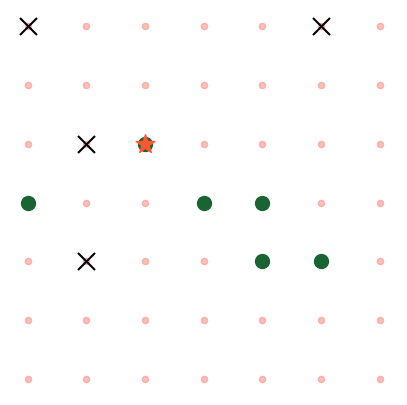

In [90]:
### Grid setup
# grid size (square)
n = 7;
spacing = 1; # always keep 1?

### port information
# number of ports on grid
m = 6;

### no-go zones
k = 4;

# boost zones
b = 0;

grid_data = initializeParam(n, spacing, m, k, b, 0.95);
port_num, port_of_origin_num, no_go_num = randomizePortsNoRepeat(grid_data)
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num,  0);

### Solve Model

Set parameter Username
Set parameter LicenseID to value 2656577
Academic license - for non-commercial use only - expires 2026-04-24
OPTIMAL
Objective value: 9.242640687119286


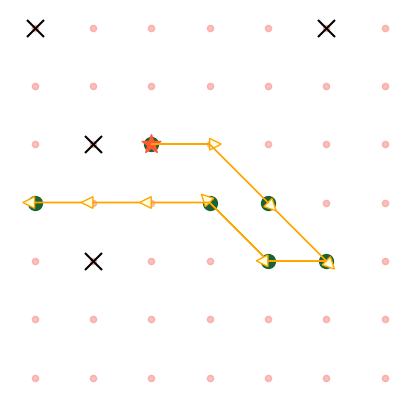

In [91]:
solver = Gurobi;
x_opt, z_opt, obj_opt = optModelMinCost(grid_data, port_num, port_of_origin_num, no_go_num, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

model = A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 2456
├ num_constraints: 7247
│ ├ AffExpr in MOI.EqualTo{Float64}: 2140
│ ├ AffExpr in MOI.LessThan{Float64}: 2651
│ ├ VariableRef in MOI.GreaterThan{Float64}: 49
│ └ VariableRef in MOI.ZeroOne: 2407
└ Names registered in the model
  └ :u, :x, :z
Set parameter Username
Set parameter LicenseID to value 2656577
Academic license - for non-commercial use only - expires 2026-04-24
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 23.6.0 23H527)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4791 rows, 2456 columns and 14678 nonzeros
Model fingerprint: 0x63cb126c
Variable types: 49 continuous, 2407 integer (2407 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 8e+00]
  Bounds range     [0e+00, 0e+00]
  RHS r

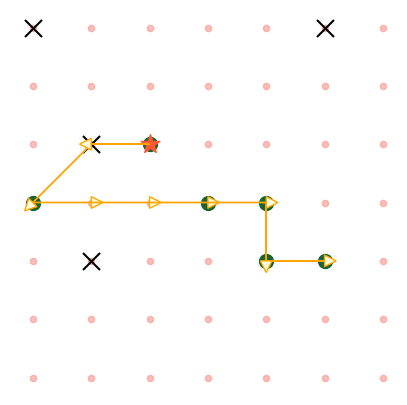

In [92]:
solver = Gurobi;
penalty_factor = 1.0;
x_opt, z_opt, obj_opt = optModelAllowNoGo(grid_data, port_num, port_of_origin_num, no_go_num, penalty_factor, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

model = A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 2456
├ num_constraints: 7247
│ ├ AffExpr in MOI.EqualTo{Float64}: 2140
│ ├ AffExpr in MOI.LessThan{Float64}: 2651
│ ├ VariableRef in MOI.GreaterThan{Float64}: 49
│ └ VariableRef in MOI.ZeroOne: 2407
└ Names registered in the model
  └ :u, :x, :z
Set parameter Username
Set parameter LicenseID to value 2656577
Academic license - for non-commercial use only - expires 2026-04-24
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 23.6.0 23H527)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4791 rows, 2456 columns and 14678 nonzeros
Model fingerprint: 0x77b77edf
Variable types: 49 continuous, 2407 integer (2407 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS r

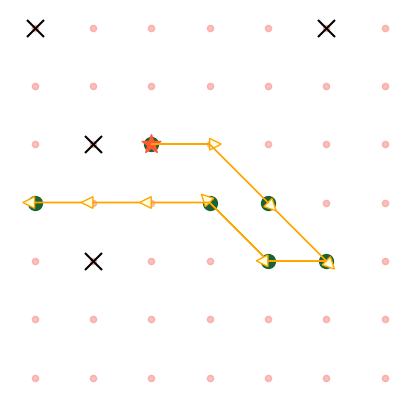

In [93]:
solver = Gurobi;
penalty_factor = 2;
x_opt, z_opt, obj_opt = optModelAllowNoGo(grid_data, port_num, port_of_origin_num, no_go_num, penalty_factor, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

model = A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 2456
├ num_constraints: 7247
│ ├ AffExpr in MOI.EqualTo{Float64}: 2140
│ ├ AffExpr in MOI.LessThan{Float64}: 2651
│ ├ VariableRef in MOI.GreaterThan{Float64}: 49
│ └ VariableRef in MOI.ZeroOne: 2407
└ Names registered in the model
  └ :u, :x, :z
Set parameter Username
Set parameter LicenseID to value 2656577
Academic license - for non-commercial use only - expires 2026-04-24
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 23.6.0 23H527)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4791 rows, 2456 columns and 14678 nonzeros
Model fingerprint: 0x0a0eb567
Variable types: 49 continuous, 2407 integer (2407 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS r

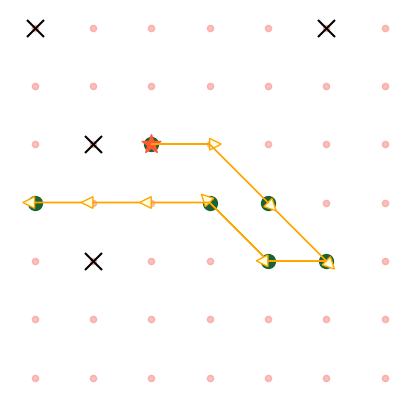

In [94]:
solver = Gurobi;
penalty_factor = 10;
x_opt, z_opt, obj_opt = optModelAllowNoGo(grid_data, port_num, port_of_origin_num, no_go_num, penalty_factor, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

In [95]:
# For if-then conditions
# utilize previous conditions to ensure good constraints

# why can't lines be eliminated by saying sum of ports with one outgoing 1?

### Max profit

Set parameter Username
Set parameter LicenseID to value 2656577
Academic license - for non-commercial use only - expires 2026-04-24
OPTIMAL
Objective value: 20836.259588908364


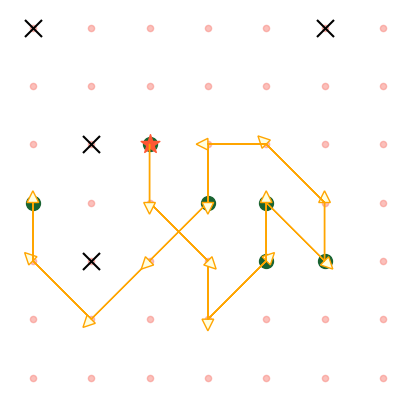

In [96]:
port_profit = randomizePortProfit(grid_data, 1000, 10000);
solver = Gurobi;
x_opt, z_opt, obj_opt = optModelMaxProfit(grid_data, port_num, port_of_origin_num, no_go_num, port_profit, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

### Maximize Profit with limiting Max Distance between two Ports

In [97]:
port_profit = randomizePortProfit(grid_data, 1000, 10000);
solver = Gurobi;
x_opt, z_opt, obj_opt = optModelMaxProfitwithMaxDist(grid_data, port_num, port_of_origin_num, no_go_num, port_profit, 8, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

Set parameter Username
Set parameter LicenseID to value 2656577
Academic license - for non-commercial use only - expires 2026-04-24
INFEASIBLE_OR_UNBOUNDED


LoadError: Model did not optimize!

### With Node Boost:

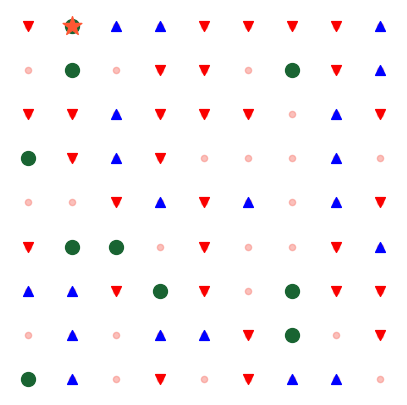

In [111]:
### Grid setup
# grid size (square)
n = 9;
spacing = 1; # always keep 1?

### port information
# number of ports on grid
m = 10;

### no-go zones
k = 30;

# boost zones
b = 20;

grid_data = initializeParam(n, spacing, m, k, b, 0.95);
port_num, port_of_origin_num, no_go_num, boost_num = randomizePortsBoostZones(grid_data)
f = visualizeGridBoost(grid_data, port_num, port_of_origin_num, no_go_num, boost_num, 0);

model = A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 6652
├ num_constraints: 20051
│ ├ AffExpr in MOI.EqualTo{Float64}: 6100
│ ├ AffExpr in MOI.LessThan{Float64}: 7299
│ ├ VariableRef in MOI.GreaterThan{Float64}: 81
│ └ VariableRef in MOI.ZeroOne: 6571
└ Names registered in the model
  └ :u, :x, :z
Set parameter Username
Set parameter LicenseID to value 2656577
Academic license - for non-commercial use only - expires 2026-04-24
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 23.6.0 23H527)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 13399 rows, 6652 columns and 40758 nonzeros
Model fingerprint: 0x0035cf0b
Variable types: 81 continuous, 6571 integer (6571 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [5e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS

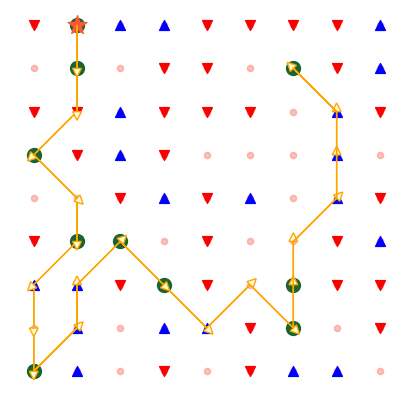

In [112]:
penalty_factor = 2;
boost_factor = 2;
x_opt, z_opt, obj_opt = optModelNoGoBoost(grid_data, port_num, port_of_origin_num, no_go_num, boost_num, penalty_factor, boost_factor, solver)
println("Objective value: $(obj_opt)");
f = visualizeGridBoost(grid_data, port_num, port_of_origin_num, no_go_num, boost_num, x_opt.data);

### With Edge Boost/Hindrances:

In [278]:
function optModelMinCostWithEdges(grid_data, port_num, port_of_origin_num, no_go_num, solver)
    grid_size = n*n;
    all_num = [i for i=0:grid_size-1];
    all_else_num = setdiff(all_num, union(port_num, no_go_num))
    # println(all_else_num)
    
    model = Model();
    # @show 
    @variable(model, x[i = 0:grid_size-1, j = 0:grid_size-1], Bin);
    # @show 
    @variable(model, z[i = 1:m], Bin);
    
    # MTZ to prevent loops
    # defined for all nodes
    @variable(model, u[i = 0:grid_size-1] >= 0);
    @constraint(model, u[1] == 0) # for POO;
    
    # edge cost: euclidean norm
    c = zeros(grid_size, grid_size);
    
    tol = 10^-5;
    
    cost = 0; 
    
    idx=0;
    # cost and same node flow
    for i = 0:grid_size-1
        sum_out_all_else = 0;
        # println(i);
    
        for j = 0:grid_size-1
            if i == j
                # no flow
                # @show 
                @constraint(model, x[i, j] == 0);
            end
    
            @constraint(model, u[i]- u[j] + grid_size*x[i, j] <= grid_size - 1);


            for i = 0:grid_size-1
                for j = 0:grid_size-1
                    if i != j
                        node_i = numToNode(i, n)
                        node_j = numToNode(j, n)
            
                        #Only for neighboring nodes:
                        if abs(node_i[1] - node_j[1]) <= 1 && abs(node_i[2] - node_j[2]) <= 1
                            base_distance = norm(numToCoord(i, n, spacing) - numToCoord(j, n, spacing))
            
                            if i < j  #Adjusting once per undirected edge
                                boost_or_hindrance = rand(Uniform(-0.99, 0.99))
            
                                # Forward edge i -> j
                                adjusted_forward = base_distance * (1 + boost_or_hindrance)
                                c[i+1, j+1] = adjusted_forward
                                cost += adjusted_forward * x[i, j]
            
                                # Reverse edge j -> i
                                adjusted_backward = base_distance * (1 - boost_or_hindrance)
                                c[j+1, i+1] = adjusted_backward
                                cost += adjusted_backward * x[j, i]
                            end
                        end
                    end
                end
            end
            
            # all edges other than the eight closest ones are zero 
            #=if c[i+1, j+1] > (sqrt(2) + tol)
                @constraint(model, x[i, j] == 0);
            end=#

            #---Alternate logic for allowing travel to closest 8 points---
            node_i = numToNode(i, n)
            node_j = numToNode(j, n)
            
            if abs(node_i[1] - node_j[1]) > 1 || abs(node_i[2] - node_j[2]) > 1
                @constraint(model, x[i, j] == 0)
            end

            
        end
    end
    
    # port of origin
    sum_in_POO = 0;
    sum_out_POO = 0;
    
    for j = 0:grid_size-1
        sum_out_POO += x[port_of_origin_num, j];
        sum_in_POO += x[j, port_of_origin_num]; 
    end
    
    # @show 
    @constraint(model, sum_out_POO==1);
    # @show 
    @constraint(model, sum_out_POO - sum_in_POO == 1);
    
    ## for other ports
    # for if-then constraints
    e = 1;
    l = -1;
    u = 2;
    sum_terminal = 0;
    
    for p=1:length(port_num)
        i = port_num[p];
        if i!=port_of_origin_num
            # println(i);
            sum_in_port = 0;
            sum_out_port = 0;
    
    
    
            for j = 0:grid_size-1
                # port of origin
                sum_out_port += x[i, j];
                sum_in_port += x[j, i];
    
                # if flow from edge is 1, then no flow in the opposite direction
                # @show 
                @constraint(model, x[i, j] + x[j, i] <= 1);
               
            end
            
            # @show 
            @constraint(model, sum_out_port >= l*z[p] +e*(1-z[p]));
            # @show 
            @constraint(model, sum_out_port <= u*(1-z[p]));
            # @show 
            @constraint(model, sum_in_port == 1);
            # @constraint(model, sum_in_port >= 1);
            # @show 
            @constraint(model, sum_out_port - sum_in_port <= 0);
    
            sum_terminal += z[p];
        end
    end
    # @show 
    @constraint(model, sum_terminal == 1);
    
    
    # for no-go zones
    for g=1:length(no_go_num)
        i = no_go_num[g];
        
        # println(i);
        
        sum_in_no_go = 0;
        sum_out_no_go = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_no_go += x[i, j];
            sum_in_no_go += x[j, i];
        
           
        end
        # @show 
        @constraint(model, sum_out_no_go == 0);
        # @show 
        @constraint(model, sum_in_no_go ==0);
        
    end
    
    # for all-else
    for a=1:length(all_else_num)
        i = all_else_num[a];
        
        # println(i);
        
        sum_out_all_else = 0;
        sum_in_all_else = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_all_else += x[i, j];
            sum_in_all_else += x[j, i];
    
            # if flow from edge is 1, then no flow in the opposite direction
            # @show 
            # @constraint(model, x[i, j] + x[j, i] <= 1);
           
        end
        # @show 
        @constraint(model, sum_out_all_else - sum_in_all_else == 0);
        
    end
    
    #objective function
    @objective(model, Min, cost);

    set_optimizer(model, solver.Optimizer);
    set_silent(model);
    optimize!(model);

    try
        x_opt = JuMP.value.(x);
        z_opt = JuMP.value.(z);
        obj_opt = objective_value(model);
        
        println(termination_status(model));
    
        return x_opt, z_opt, obj_opt, model, c
    catch
    # else
        error("Model did not optimize!")
    end

end

optModelMinCostWithEdges (generic function with 1 method)

In [297]:
### Grid setup
# grid size (square)
n = 10;
spacing = 1;|
### port information
# number of ports on grid
m = 14;
### no-go zones
k = 10;
grid_data = initializeParam_(n, spacing, m, k);
port_num, port_of_origin_num, no_go_num = randomizePortsNoRepeat(grid_data)

([85; 21; … ; 97; 63;;], 94, [38; 91; … ; 57; 18;;])

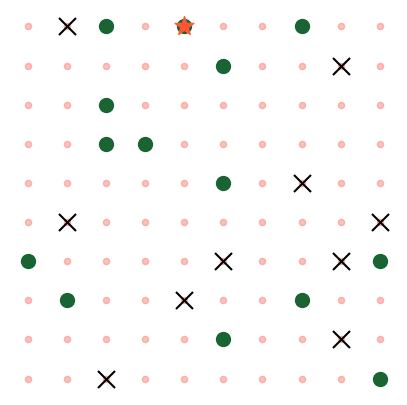

In [298]:
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, 0);

In [299]:
solver = Gurobi;
x_opt, z_opt, obj_opt, model, c = optModelMinCostWithEdges(grid_data, port_num, port_of_origin_num, no_go_num, solver)

Set parameter Username
Set parameter LicenseID to value 2656577
Academic license - for non-commercial use only - expires 2026-04-24
OPTIMAL


(2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 0:99
    Dimension 2, 0:99
And data, a 100×100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

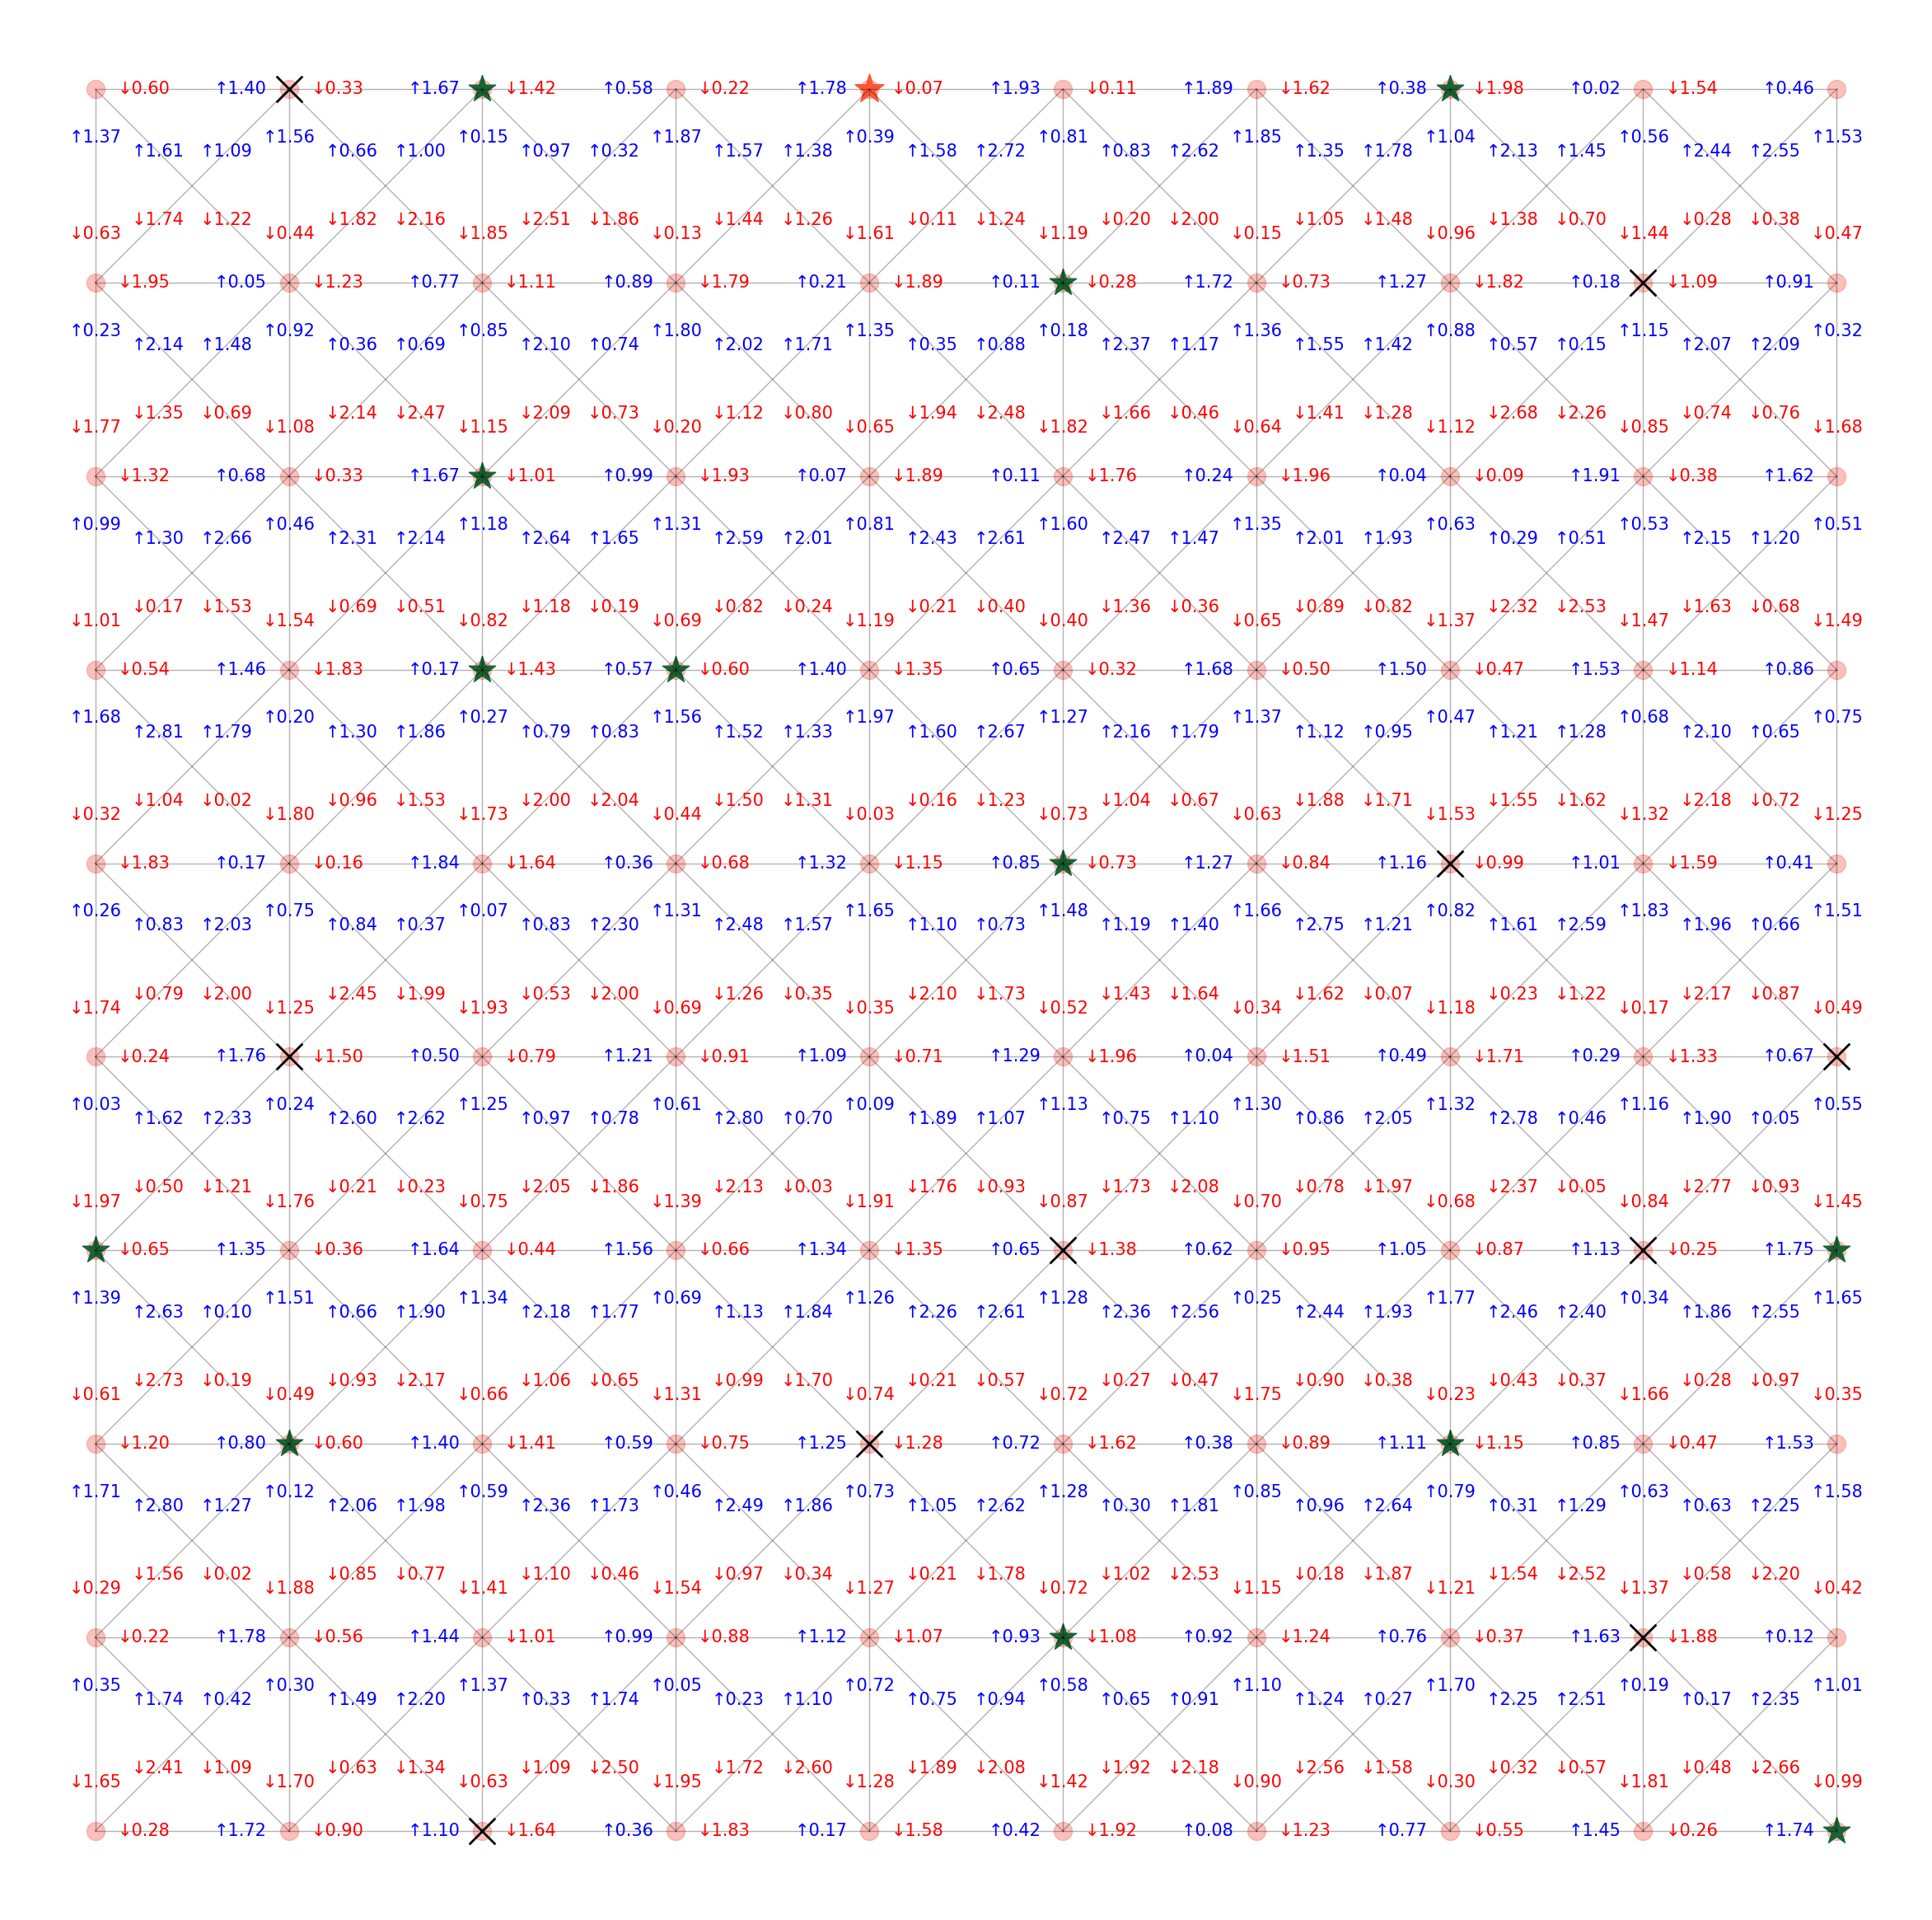

In [300]:
f = visualizeGridWithEdges(grid_data, port_num, port_of_origin_num, no_go_num, 0,c);

#### Normal Case: 

#### Edge-Boost Case:

(100, 100)


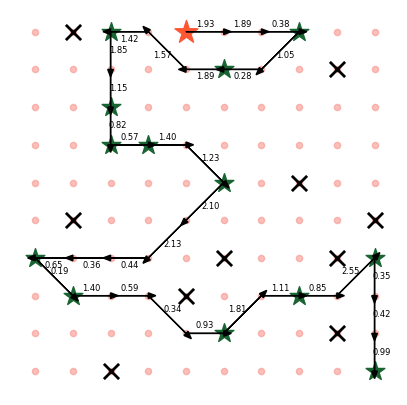

In [302]:
println(size(x_opt));
f = visualizeGridWithEdgesSol(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data, c);

# With Soft Port Priority Constraints:

In [303]:
function optModelMinCostWithPrioritiesSoft(grid_data, port_num, port_of_origin_num, no_go_num, solver, port_priority, λ)
    n = Int(grid_data[1])
    spacing = grid_data[2]
    m = length(port_num)  # number of ports
    grid_size = n * n

    all_num = [i for i=0:grid_size-1]
    all_else_num = setdiff(all_num, union(port_num, no_go_num))

    model = Model()
    # @show 
    @variable(model, x[i=0:grid_size-1, j=0:grid_size-1], Bin)
    # @show 
    @variable(model, z[i=1:m], Bin)

    # MTZ to prevent loops
    # defined for all nodes
    @variable(model, u[i=0:grid_size-1] >= 0)
    @constraint(model, u[port_of_origin_num] == 0)
    
    @variable(model, y[p=1:m], Int)      # visit order variable
    @variable(model, s[p=1:m, q=1:m] >= 0)  # penalty slack variable


    # edge cost: euclidean norm
    c = zeros(grid_size, grid_size)
    cost = 0

    tol = 1e-5

    for i = 0:grid_size-1
        for j = 0:grid_size-1
            if i == j
                @constraint(model, x[i, j] == 0)
            end

            node_i = numToNode(i, n)
            node_j = numToNode(j, n)

            #Only allowing nearest 8 neighbors
            if abs(node_i[1] - node_j[1]) > 1 || abs(node_i[2] - node_j[2]) > 1
                @constraint(model, x[i, j] == 0)
            else
                base_distance = norm(numToCoord(i, n, spacing) - numToCoord(j, n, spacing))
                c[i+1, j+1] = base_distance
                cost += c[i+1, j+1] * x[i, j]

                #MTZ constraint for subtour elimination:
                @constraint(model, u[i] - u[j] + grid_size * x[i, j] <= grid_size - 1)
            end
        end
    end

    #Constraints for port of origin:
    sum_out_poo = sum(x[port_of_origin_num, j] for j=0:grid_size-1)
    sum_in_poo = sum(x[j, port_of_origin_num] for j=0:grid_size-1)
    @constraint(model, sum_out_poo == 1)
    @constraint(model, sum_out_poo - sum_in_poo == 1)

    #Constraints for other ports:
    sum_terminal = 0
    for p=1:m
        i = port_num[p]
        if i != port_of_origin_num
            sum_out_port = sum(x[i, j] for j=0:grid_size-1)
            sum_in_port = sum(x[j, i] for j=0:grid_size-1)

            @constraint(model, sum_out_port >= -1*z[p] + 1*(1-z[p]))
            @constraint(model, sum_out_port <= 2*(1-z[p]))
            @constraint(model, sum_in_port == 1)
            @constraint(model, sum_out_port - sum_in_port <= 0)

            sum_terminal += z[p]
        end
    end
    @constraint(model, sum_terminal == 1)

    #Constraints for no-go zones:
    for g=1:length(no_go_num)
        i = no_go_num[g]
        sum_in = sum(x[j, i] for j=0:grid_size-1)
        sum_out = sum(x[i, j] for j=0:grid_size-1)
        @constraint(model, sum_in == 0)
        @constraint(model, sum_out == 0)
    end

    #Flow conservation:
    for a=1:length(all_else_num)
        i = all_else_num[a]
        sum_out = sum(x[i, j] for j=0:grid_size-1)
        sum_in = sum(x[j, i] for j=0:grid_size-1)
        @constraint(model, sum_out - sum_in == 0)
    end

    #Priority Order Penalty Constraints:
    for p=1:m
        for q=1:m
            #Only compare if both p and q are visiting ports (i.e. not the origin)
            if port_num[p] != port_of_origin_num && port_num[q] != port_of_origin_num
                if port_priority[port_num[p]] < port_priority[port_num[q]]
                    @constraint(model, s[p, q] >= y[p] - y[q])
                end
            end
        end
    end


    #Visit order must be valid:
    for p=1:m
        if port_num[p] != port_of_origin_num
            @constraint(model, 1 <= y[p] <= m-1)
        end
    end

    #Final objective:
    @objective(model, Min, cost + λ * sum(
    s[p, q] for p=1:m, q=1:m 
    if port_num[p] != port_of_origin_num && port_num[q] != port_of_origin_num &&
       port_priority[port_num[p]] < port_priority[port_num[q]]
    ))


    set_optimizer(model, solver.Optimizer)
    set_silent(model)
    optimize!(model)

    try
        x_opt = JuMP.value.(x)
        z_opt = JuMP.value.(z)
        y_opt = JuMP.value.(y)
        s_opt = JuMP.value.(s)
        obj_opt = objective_value(model)

        println(termination_status(model))

        return x_opt, z_opt, y_opt, s_opt, obj_opt, model, c
    catch
        error("Model did not optimize!")
    end
end

optModelMinCostWithPrioritiesSoft (generic function with 1 method)

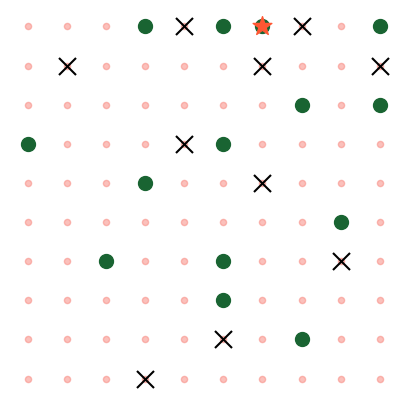

In [304]:
### Grid setup
# grid size (square)
n = 10;
spacing = 1; # always keep 1?
### port information
# number of ports on grid
m = 14;
### no-go zones
k = 10;
grid_data = initializeParam_(n, spacing, m, k);
port_num, port_of_origin_num, no_go_num = randomizePortsNoRepeat(grid_data)
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, 0);

#### Normal Case:

Set parameter Username
Set parameter LicenseID to value 2656577
Academic license - for non-commercial use only - expires 2026-04-24
OPTIMAL
(100, 100)


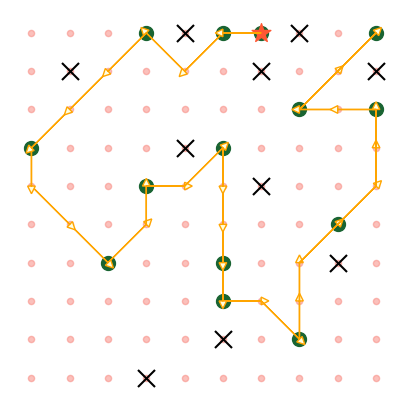

In [305]:
solver = Gurobi;
x_opt, z_opt, obj_opt = optModelMinCost(grid_data, port_num, port_of_origin_num, no_go_num, solver);
println(size(x_opt));
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

#### Soft port constraints case:

Set parameter Username
Set parameter LicenseID to value 2656577
Academic license - for non-commercial use only - expires 2026-04-24
OPTIMAL
(100, 100)


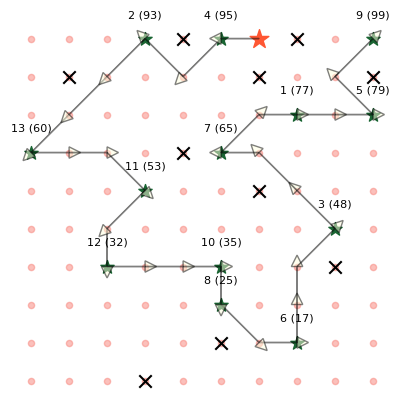

In [306]:
solver = Gurobi

#Generating priorities dynamically:
port_priority = generatePortPriorities(port_num, port_of_origin_num)
#Penalty term:
λ = 1000000000000

x_opt, z_opt, y_opt, s_opt, obj_opt, model, c = optModelMinCostWithPrioritiesSoft(
    grid_data, port_num, port_of_origin_num, no_go_num, solver, port_priority, λ)

println(size(x_opt))
f = visualizeGridWithPriorities(
    grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data, port_priority)
show()

In [307]:
printVisitOrder(port_num, port_of_origin_num, y_opt)


--- Port Visit Order ---
Visit port 77 at order 1.0
Visit port 93 at order 1.0
Visit port 48 at order 1.0
Visit port 95 at order 1.0
Visit port 79 at order 1.0
Visit port 17 at order 1.0
Visit port 65 at order 1.0
Visit port 25 at order 13.0
Visit port 99 at order 13.0
Visit port 35 at order 13.0
Visit port 53 at order 13.0
Visit port 32 at order 13.0
Visit port 60 at order 13.0
------------------------



### Tradeoff Analysis between Minimizing Cost and Maximizing Profit:

In [318]:
function tradeoffAnalysisWithConstraints(grid_data, port_num, port_of_origin_num, no_go_num, port_profit, solver, lambda_values)
    n = Int(grid_data[1])
    spacing = grid_data[2]
    m = length(port_num)
    grid_size = n * n
    all_num = [i for i = 0:grid_size-1]
    all_else_num = setdiff(all_num, union(port_num, no_go_num))

    results = []

    for λ in lambda_values
        model = Model()
        @variable(model, x[i=0:grid_size-1, j=0:grid_size-1], Bin)
        @variable(model, u[i=0:grid_size-1] >= 0)   
        @variable(model, w[p=1:m], Bin)            

        c = zeros(grid_size, grid_size)
        profit = 0.0
        edge_cost = 0.0

        tol = 1e-5

        for i = 0:grid_size-1
            for j = 0:grid_size-1
                if i == j
                    @constraint(model, x[i, j] == 0)
                end

                c[i+1, j+1] = norm(numToCoord(i, n, spacing) - numToCoord(j, n, spacing))
                edge_cost += c[i+1, j+1] * x[i, j]

                if abs(numToNode(i, n)[1] - numToNode(j, n)[1]) > 1 || abs(numToNode(i, n)[2] - numToNode(j, n)[2]) > 1
                    @constraint(model, x[i, j] == 0)
                end

                @constraint(model, u[i] - u[j] + grid_size * x[i, j] <= grid_size - 1)
            end
        end

        # port of origin flow
        @constraint(model, sum(x[port_of_origin_num, j] for j=0:grid_size-1) == 1)
        @constraint(model, sum(x[j, port_of_origin_num] for j=0:grid_size-1) == 0)

        # port constraints
        for p=1:m
            i = port_num[p]
            if i != port_of_origin_num
                sum_in = sum(x[j, i] for j=0:grid_size-1)
                sum_out = sum(x[i, j] for j=0:grid_size-1)

                @constraint(model, sum_in <= w[p])
                @constraint(model, sum_out <= w[p])
                @constraint(model, sum_in == sum_out)

                profit += port_profit[p] * w[p]
            end
        end

        # no-go zones
        for g in no_go_num
            @constraint(model, sum(x[j, g] for j=0:grid_size-1) == 0)
            @constraint(model, sum(x[g, j] for j=0:grid_size-1) == 0)
        end

        # flow conservation
        for i in all_else_num
            @constraint(model, sum(x[i, j] for j=0:grid_size-1) == sum(x[j, i] for j=0:grid_size-1))
        end

        # final objective
        @objective(model, Max, profit - λ * edge_cost)

        set_optimizer(model, solver.Optimizer)
        set_silent(model)
        optimize!(model)

        if termination_status(model) == MOI.OPTIMAL
            profit_val = 0.0
            edge_cost_val = 0.0
            for p=1:length(port_profit)
                profit_val += port_profit[p] * (JuMP.hasvalue(w[p]) ? value(w[p]) : 0)
            end
            for i=0:grid_size-1, j=0:grid_size-1
                edge_cost_val += c[i+1, j+1] * (JuMP.hasvalue(x[i, j]) ? value(x[i, j]) : 0)
            end
            push!(results, (λ, profit_val, edge_cost_val))
        else
            push!(results, (λ, NaN, NaN))
        end
    end

    return results
end


tradeoffAnalysisWithConstraints (generic function with 1 method)